In [1]:
%load_ext autoreload
%autoreload 2

import os

import jax
jax.config.update("jax_enable_x64", True)

import numpyro
numpyro.set_host_device_count(4)

import numpy as np
import scipy.optimize

import ultraplot as uplt

In [2]:
from des_y6_imsim_analysis import bump
from des_y6_imsim_analysis.stats import compute_model_chi2_info, measure_map, run_mcmc
from des_y6_imsim_analysis.utils import measure_m_dz, read_data

In [3]:
fnames = [
    "../../data/N_gamma_alpha_v2_statistical.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-occupancy.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-neighbor.hdf5",
    "../../data/N_gamma_alpha_v2_statistical-neighbor-occupancy.hdf5",
]

keys = [
    os.path.basename(fname).replace(".hdf5", "").split("_")[-1]
    for fname in fnames
]

seeds = [213432, 6457645, 213, 7878546]

fit_data = {}

model_module = bump

for key, fname, seed in zip(keys, fnames, seeds):
    data = read_data(fname)

    model_data = model_module.make_model_data(
        z=data.z,
        nzs=data.nzs,
        mn=data.mn,
        cov=data.cov,
        mn_pars=data.mn_pars,
        zbins=data.zbins,
        fixed_param_values={"w": 0.1, "g_b0": 0.0, "g_b1": 0.0, "g_b2": 0.0, "g_b3": 0.0},
        num_bins=9,
    )

    map_params = measure_map(
        model_module=model_module,
        model_data=model_data,
        seed=seed,
    )

    mcmc = run_mcmc(
        model_module=model_module,
        model_data=model_data,
        init_params=map_params,
        seed=seed,
    )

    chi2_info = compute_model_chi2_info(
        model_module=model_module,
        model_data=model_data,
        data=data,
        params=map_params,
    )

    fit_data[key] = {
        "map_params": map_params,
        "mcmc": mcmc,
        "model_data": model_data,
        "data": data,
    }

    print("key:", key)
    print("chi2:", chi2_info['chi2'])
    print("dof:", chi2_info['dof'])
    print("p-value:", chi2_info['p_value'])
    print("m vals:\n    model: %r\n    data: %r\n     err: %r" % (
        (chi2_info['model_mn'][:4] - 1).tolist(),
        (data.mn[:4] - 1).tolist(),
        (np.sqrt(np.diag(data.cov)[:4])).tolist(),
    ))
    print("", flush=True)

key: statistical
chi2: 3.832692091685576
dof: 8
p-value: 0.87189417323875
m vals:
    model: [-0.005961562361381678, 0.014455806637001523, 0.016856872871886308, 0.009677856668955265]
    data: [-0.006994349826206503, 0.016036566228740057, 0.017247239530250313, 0.009428620061380233]
     err: [0.004593226944328782, 0.006142812018330256, 0.005437871858005932, 0.009363355942622971]

key: statistical-occupancy
chi2: 4.016246685503746
dof: 8
p-value: 0.8556546585114898
m vals:
    model: [-0.008156223707055155, 0.010562624931793163, 0.016423324155631747, 0.008193864775689175]
    data: [-0.008923099284016134, 0.012461296733357496, 0.017138348042496254, 0.007125125944023258]
     err: [0.005081500549334836, 0.006317458726575935, 0.005407761042726535, 0.009482393424392194]

key: statistical-neighbor
chi2: 5.98443953225779
dof: 8
p-value: 0.6489749805732526
m vals:
    model: [-0.004360889281021851, 0.0102167419533723, 0.019093082171642184, 0.0061169702173813345]
    data: [-0.0060081569373531

In [4]:
rng = np.random.default_rng(75865874)

final_mdz = {}
n_per = 1000

for key in fit_data.keys():
    samples = fit_data[key]["mcmc"].get_samples()

    mdz = measure_m_dz(
        model_module=model_module,
        model_data=fit_data[key]["model_data"],
        samples=samples,
        return_dict=True,
    )
    n_samp = mdz[list(mdz.keys())[0]].shape[0]
    inds = rng.choice(n_samp, n_per, replace=False)
    for k, v in mdz.items():
        if k not in final_mdz:
            final_mdz[k] = []
        final_mdz[k].append(v[inds])

for k in final_mdz.keys():
    final_mdz[k] = np.concatenate(final_mdz[k], axis=0)

In [5]:
m_mn = [np.mean(mdz[f"m_b{i}"]) for i in range(4)]
m_sd = [np.std(mdz[f"m_b{i}"]) for i in range(4)]

dz_mn = [np.mean(mdz[f"dz_b{i}"]) for i in range(4)]
dz_sd = [np.std(mdz[f"dz_b{i}"]) for i in range(4)]

print("|--------------------------------------------|")
print("| bin | m [10^-3, 3sigma] | dz               |")
print("|--------------------------------------------|")
for i in range(4):
    print(
        "| %d   | %+5.1f +/- %-5.1f   | %+0.3f +/- %0.3f |" % (
            i, m_mn[i]/1e-3, m_sd[i]/1e-3 * 3, dz_mn[i], dz_sd[i]
        )
    )
print("|--------------------------------------------|")

|--------------------------------------------|
| bin | m [10^-3, 3sigma] | dz               |
|--------------------------------------------|
| 0   |  -6.9 +/- 16.5    | -0.010 +/- 0.005 |
| 1   |  +7.2 +/- 20.1    | -0.020 +/- 0.006 |
| 2   | +17.8 +/- 17.1    | +0.003 +/- 0.005 |
| 3   |  +4.1 +/- 28.7    | -0.034 +/- 0.009 |
|--------------------------------------------|


In [6]:
arr = np.array(
    [mdz[f"m_b{i}"] for i in range(4)]
    + [mdz[f"dz_b{i}"] for i in range(4)]
)

In [7]:
corr = np.corrcoef(arr)

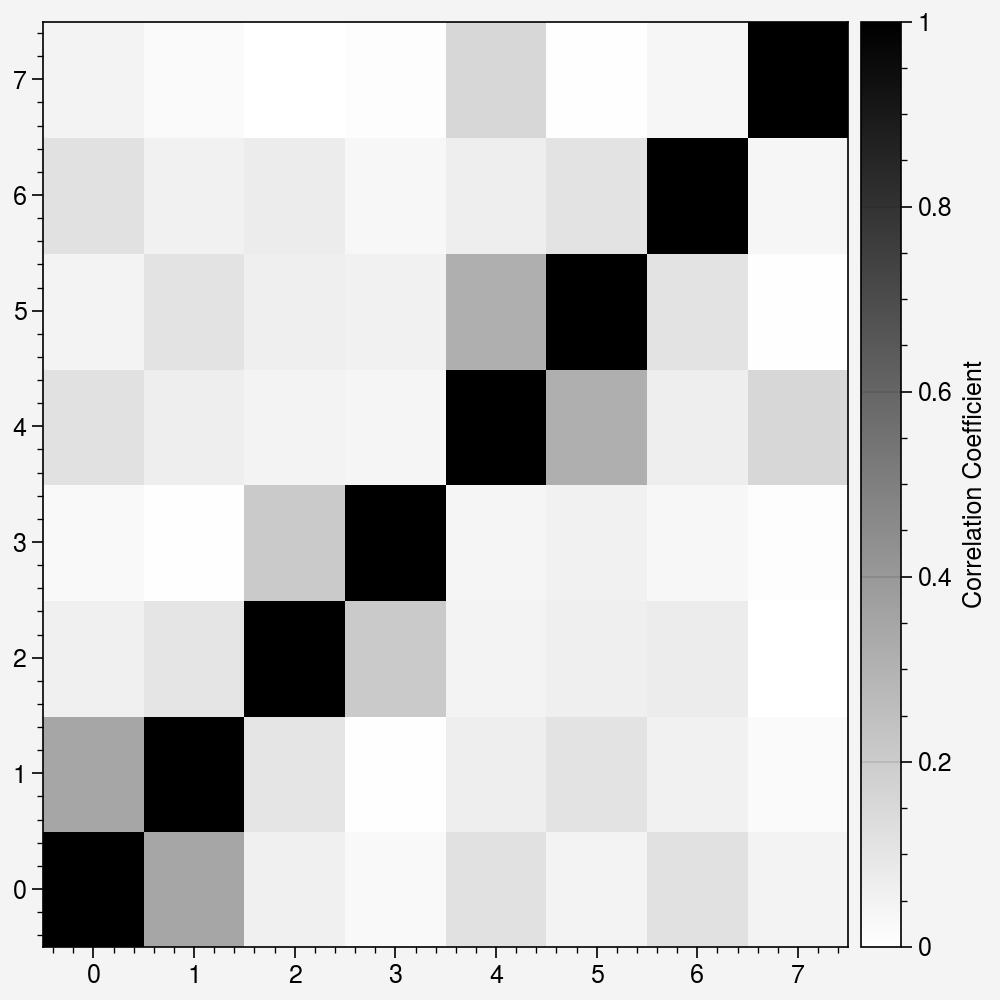

In [8]:
fig, axs = uplt.subplots(figsize=(5, 5))

m = axs.pcolormesh(np.abs(corr), vmin=0, vmax=1, cmap="gray_r", discrete=False)
axs.colorbar(m, label="Correlation Coefficient")
axs.format(grid=False)